# Gaussian Process Regression and Bayesian Global Optimisation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import gp as gp
import kernels as kernels
import acquisitions as acquisitions 
import bayesopt as bayesopt
import importlib

importlib.reload(gp)
importlib.reload(kernels)
importlib.reload(acquisitions)
importlib.reload(bayesopt)
%matplotlib inline

plt.rcParams['xtick.major.pad']='2'
plt.rcParams['ytick.major.pad']='2'


#### We want to maximise the following 1-dimensional function,
$$\mathrm{maximise}_x\quad f(x)$$
where
$$f(x) = \sin(x) + \sin(2x) + \epsilon$$


/var/folders/zt/6v8jtxmn2cldmd9wt7mq07pw0000gn/T/ipykernel_58620/3990505763.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = np.arange(bounds[:, 0], bounds[:, 1], 0.02).reshape(-1, 1)


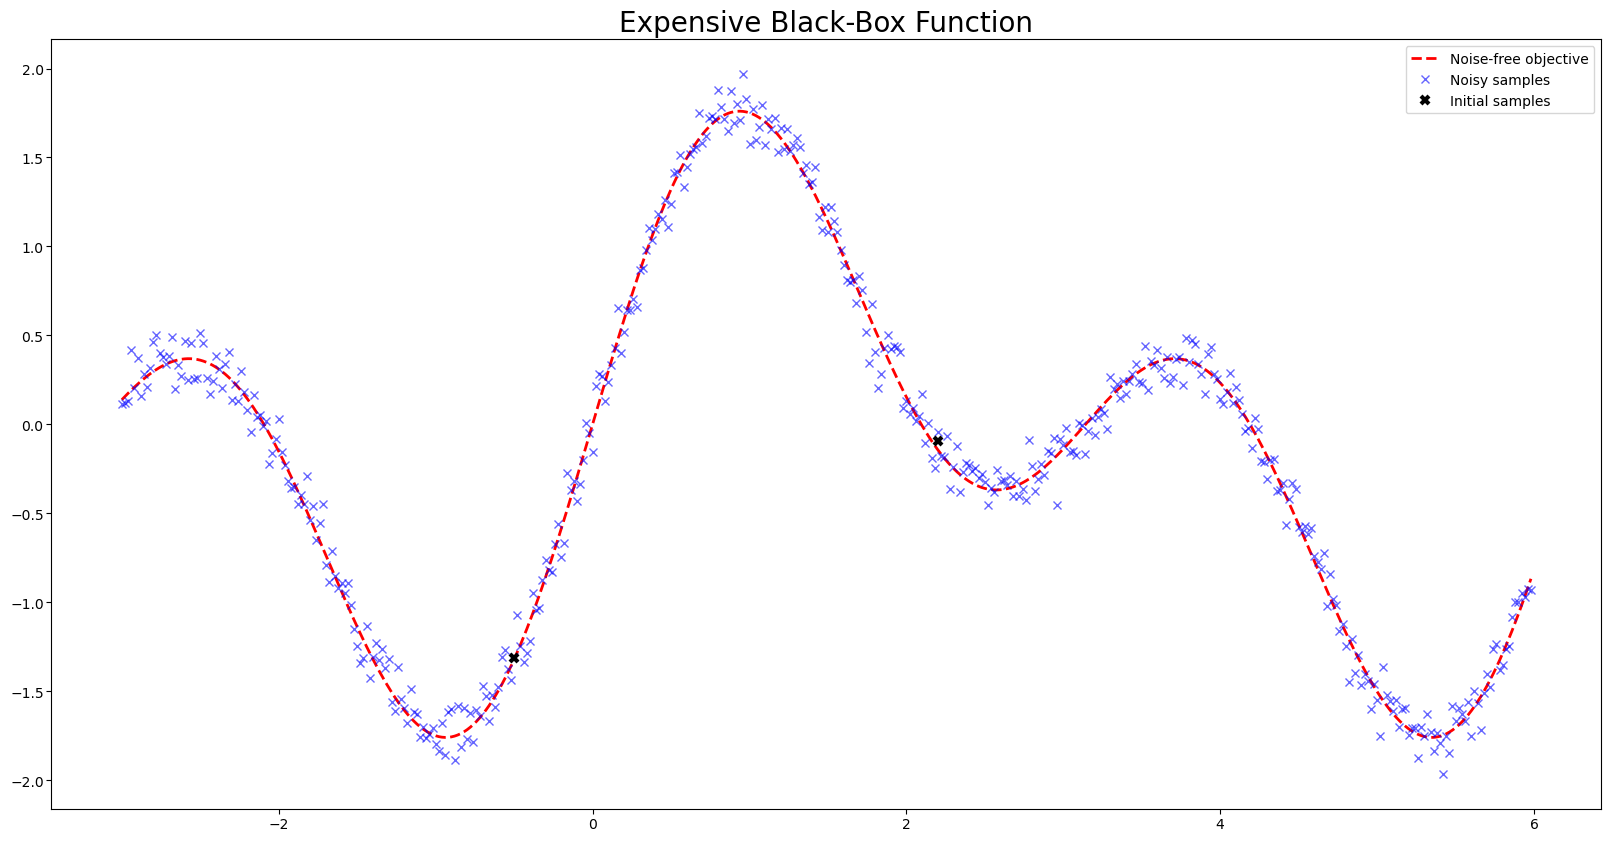

In [10]:
bounds = np.array([[-3, 6]])
noise_level = 0.1

np.random.seed(4)

def f(X, noise_level=noise_level):
    return np.sin(X) + np.sin(2 * X) + noise_level * np.random.randn(*X.shape)

X_init = np.array([[-0.5], [2.2]])
Y_init = f(X_init)

# Bound our random variable X
X = np.arange(bounds[:, 0], bounds[:, 1], 0.02).reshape(-1, 1)

# First let's have a noise-free objective function
Y = f(X, 0)

#Plot optimisation objective with the appropriate noise levels
plt.figure(figsize=(20, 10))
plt.plot(X, Y, 'r--', lw=2, label='Noise-free objective');
plt.plot(X, f(X), 'bx', lw=1, alpha=0.6, label='Noisy samples');
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples');
plt.title("Expensive Black-Box Function", fontdict = {'fontsize' : 20})
plt.legend()
plt.show()


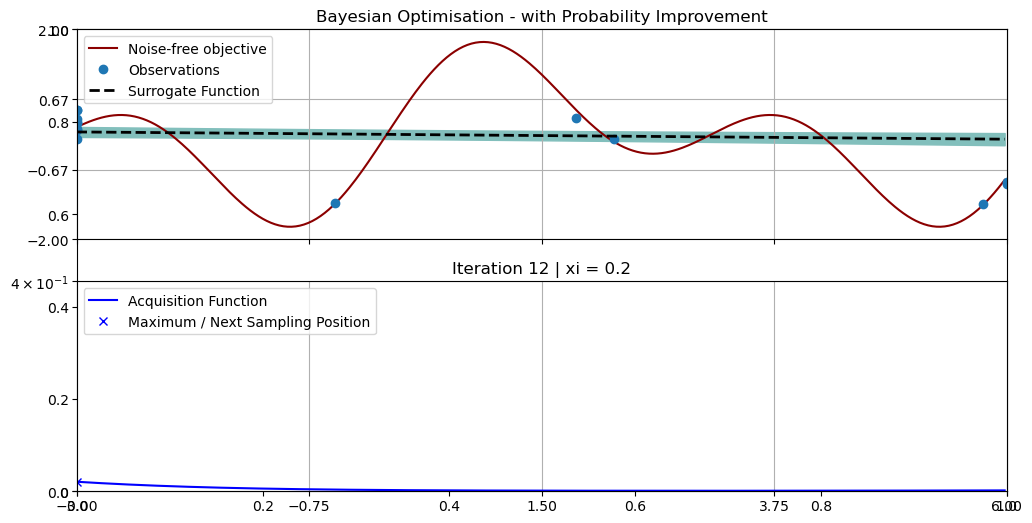

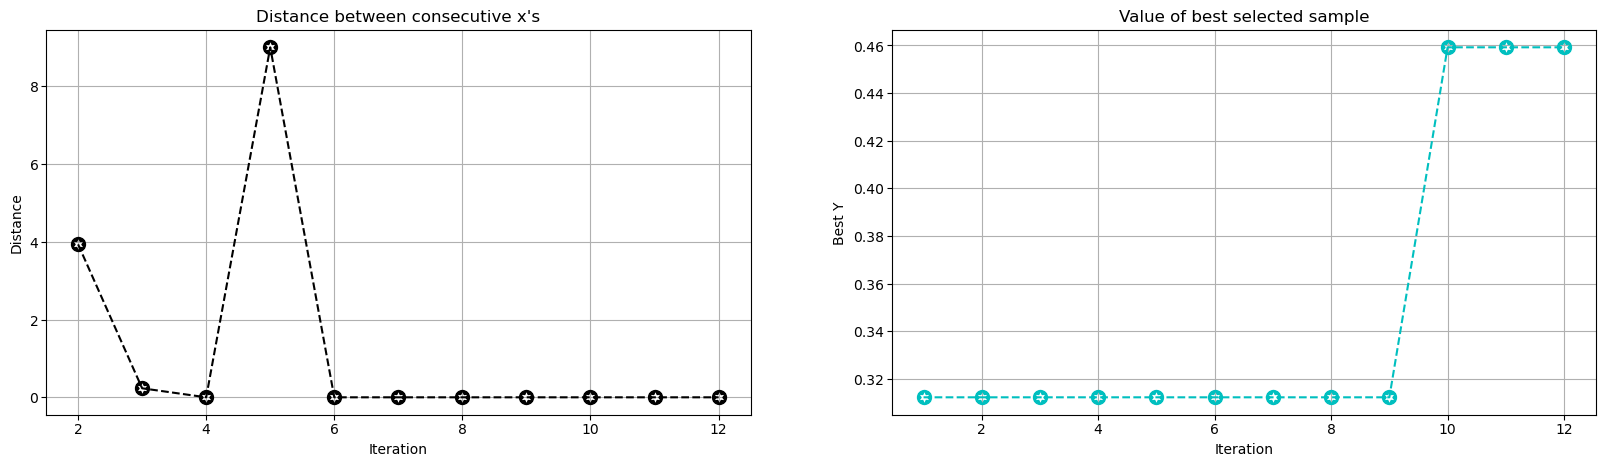

In [11]:
# Expected Output:
# 1) An animation of the Bayesian optimisation process which will lead to the close approximation of the surrogate function to the black box one.
# 2) An image of the final iteration (result) of the BO process (expected to be at a converged state)
# 3) Two plots indicating extra convergence heuristics

# Probability Improvement (PI)
bayesopt.BO(X_init, Y_init, f, noise_level, bounds, n_iter=12, xi=0.2, title='Bayesian Optimisation - with Probability Improvement', X=X, Y=Y).call_animation(acquisitions.probability_improvement)

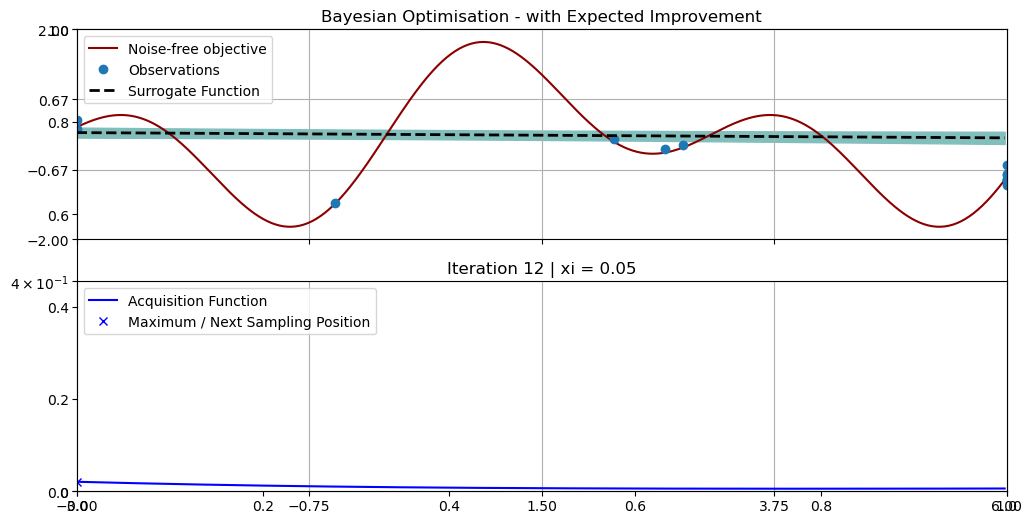

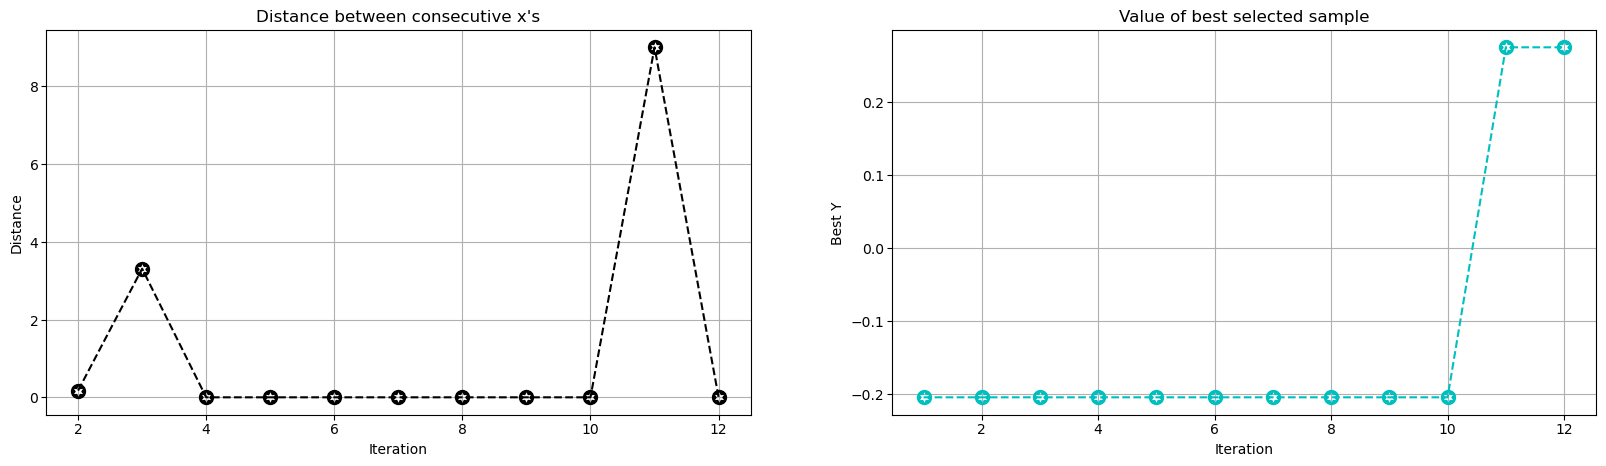

In [12]:
# Expected Output: Similar as above

# Expected Improvement (EI)
# There is currently a bug here: to run this, the step data needs to be reloaded.
# This is likely because some data was not updated during initialization.
bayesopt.BO(X_init, Y_init, f, noise_level, bounds, n_iter=12, xi=0.05, title='Bayesian Optimisation - with Expected Improvement', X=X, Y=Y).call_animation(acquisitions.expected_improvement)

### Higher Dimensions

Let's assume that we want to approximate a higher dimensional function via the surrogate model, using a Gaussian Process regression.

We have the function of a N-dimensional dataset $X$, 
$$
f(X) = \tanh^2\left(\frac{||X||_F}{2}\right) + \boldsymbol{\epsilon}
$$

where we take the Frobenius norm of $X$ per column (second dimension).

Let's now investigate the benefits of performing hyper-parameter optimisation on the Gaussian process regression model during the fitting process by maximising the log marginal likelihood, before performing tasks such as Bayesian optimisation to find global optima.

In [244]:
def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 3, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.winter, linewidth=0.5, alpha=0.3, antialiased=False)
    ax.scatter(X_train[:,0], X_train[0:,1], Y_train, c=Y_train, cmap=cm.autumn)
    ax.set_title(title)

noise_2D = 0.1
np.random.seed(3408944656)

def f2D(X, noise_2D=noise_2D):
    return np.tanh(0.5 * np.linalg.norm(X, axis=1))**2 + noise_2D * np.random.randn(len(X))


rx, ry = np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1)
gx, gy = np.meshgrid(rx, rx)
X_2D = np.c_[gx.ravel(), gy.ravel()]

Y_1D = f2D(X_2D, 0)

X_2D_train = np.random.uniform(-8, 8, (100, 2))

Y_1D_train = f2D(X_2D_train)

# TODO Q2.9b
#-------------------------------------------------------------
# FIXME
nu_s = []
#------------------------------------------------------------

for nu in nu_s:

    m = kernels.Matern(nu=nu, length_scale=1.0, variance=1.0)
    gpr = gp.GPR(kernel=m, noise_level=noise_2D**2, n_restarts=20)

    plt.figure(figsize=(20,10))
    gpr.X_train = X_2D_train
    gpr.y_train = Y_1D_train
    mu_s = gpr.predict(X_2D)
    plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_1D_train, r'Before hyper-parameter optimisation: $\ell$=1.00, $\sigma^2_f$=1.00', 1)

    gpr.update(X_2D_train, Y_1D_train)
    params = gpr.kernel.get_hyperparameters()
    mu_s = gpr.predict(X_2D)
    print(f'Running a Gaussian process with a Matern class covariance function with value nu = {nu}')
    for key in sorted(params): print(f"{key} : {params[key]}")

    plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_1D_train,
            r'After hyper-parameter optimisation: $\ell$={:.2f}, $\sigma^2_f$={:.2f}'.format(params["length_scale"], params["variance"]), 2)

    plot_gp_2D(gx, gy, Y_1D, X_2D_train, Y_1D_train, f'Original function without noise', 3)
    plt.show()
    print('-------------------------------------------------------------------------------------------------------------------------')

# Expected output per loop/row:
# Three 3D plots: GP approximation with default parameters (left), GP approximation with learned parameters (middle), and original function to be approximated (right)

### Hyperparameter tuning via different types of searches 
#### Grid Search, Random Search, Bayes Search

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


[CV] END .hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.0s
[CV] END .hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.0s
[CV] END .hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.0s
[CV] END .hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.1s
[CV] END .hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.1s
[CV] END hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.9s
[CV] END hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.9s
[CV] END hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   2.0s
[CV] END hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.8s
[CV] END hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.9s
[CV] END .hidden_layer_sizes=(200,), learning_rate_init=0.01; total time=   1.6s
[CV] END .hidden_layer_sizes=(200,), learning_rate_init=0.01; total time=   1.4s
[CV] END .hidden_layer_sizes

<Figure size 1000x700 with 0 Axes>

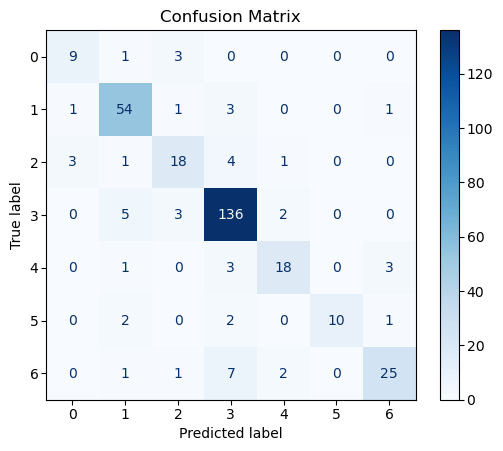

Random Search Time: 35.74368405342102
Random Search Best Params: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (200,)}
Random Search Test Score: 0.8385093167701864
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.83      0.90      0.86        60
           2       0.69      0.67      0.68        27
           3       0.88      0.93      0.90       146
           4       0.78      0.72      0.75        25
           5       1.00      0.67      0.80        15
           6       0.83      0.69      0.76        36

    accuracy                           0.84       322
   macro avg       0.82      0.75      0.78       322
weighted avg       0.84      0.84      0.84       322



<Figure size 1000x700 with 0 Axes>

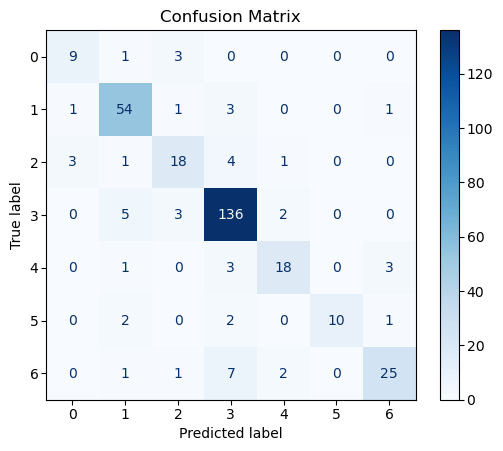

Bayes Search Time: 149.88116693496704
Bayes Search Best Params: OrderedDict([('hidden_layer_sizes', 253), ('learning_rate_init', 0.0004489541422854387)])
Bayes Search Test Score: 0.8291925465838509
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.69      0.64        13
           1       0.81      0.85      0.83        60
           2       0.70      0.59      0.64        27
           3       0.89      0.95      0.92       146
           4       0.76      0.76      0.76        25
           5       0.90      0.60      0.72        15
           6       0.81      0.69      0.75        36

    accuracy                           0.83       322
   macro avg       0.78      0.73      0.75       322
weighted avg       0.83      0.83      0.83       322



<Figure size 1000x700 with 0 Axes>

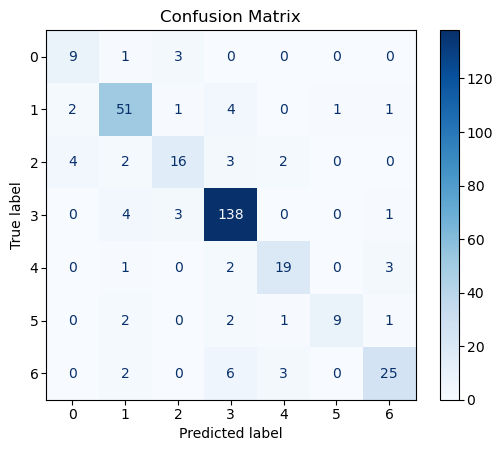

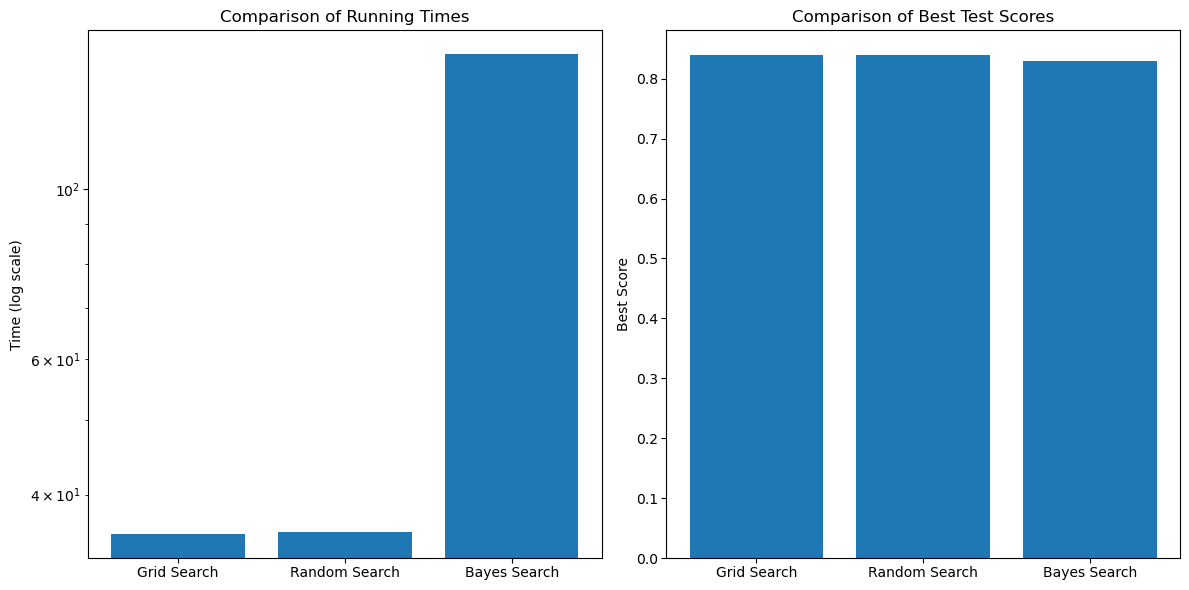

In [245]:
from hyperparameter_search import perform_hyperparameter_tuning

# run the hyperparameter tuning
perform_hyperparameter_tuning()